# Twitter - NBA Sentiment Analysis
### Overview
The goal of this project was to see if there was a relationship between the overall sentiment on social media of an NBA player, and that player's future performance. The idea stemmed from my own interests. I spend a lot of time both on Twitter and watch NBA basketball and most of my Twitter feed has become basketball related. Socail media is a brutal place and I often see tweets that slander a specific player or team, and I also see NBA players themselves tweeting and responding to these. I began to wonder if players are affected by these negative tweets, if perhaps it shakes their confidence. To explore this idea in more depth, I gathered data from Twitter and from NBA.com on 16 selected players and took a closer look.

### The Data
To gather the necessary data, I used 2 packages in python. For the NBA player I used NBA_api that alllows you to scrape data from NBA.com. I used this to get the gamelogs for each of the 16 selected players going back to 2012. I selected the 16 players to do analysis based on a few factors. I wanted to get a diverse group of players that represent various levels of social media exposure. I selected players I know are active on social media LeBrin James and Kevin Durant. I also tried to get get players with little to no social media precense. I selected some players from the big market teams and some form small market teamas to see if the bright lights amplify the effects. I selected some rookies who grew up on social media and some veterans who didn't. 

As for the Twitter data, I used the snscrape library. I had hoped to get experience with the Twitter API but their search only let you get tweets from 7 days prior which proved to be an issue I couldn't work around. The snscrape package allowed me to search for old tweets mentioning each player with more than a certain amount of tweets. For most players I selected tweets with more than 100 likes, but for the superstars (LeBron, KD and Steph Curry) I chose a 300 like minimum because they are much more popular. The reason for the minimum like amount is that their is simply so many tweets mentioning NBA players and the players themselves likely only see tweets with a large amount of likes. After collecting all the Twitter data, I ran the content of the tweets through AWS comprehend to get insight into the sentiment behind the tweets.  

In [1]:
import pandas as pd

### Importing the Twitter Data
Here, we will map the sentiment of tweet to a numerical value. Neutral and Mixed will be 0, Negative will be -1 and Positive will be 1. The reason for this is that it will allow us to sum the sentiment for each day to get an overall understanding of the sentiment on each day for each player.

In [2]:
twitter_df = pd.read_json('Twitter-data\\data\\all_tweets.json', orient='records')
twitter_df.head()

,Datetime,tweet_id,Text,Username,Verified,likes,replies,player_id,sentiment,pos_score,neg_score,neutral_score,mixed_score
0,2021-12-20 23:00:58,1473065920373215234,No one can stop @KDTrey5 🥵 https://t.co/4FR08n...,scoreboard_hq,False,643,21,201142,NEUTRAL,0.307467,0.013274,0.678667,0.000591
1,2021-12-20 20:31:24,1473028280076804099,"Updated MVP tracker, via @bball_ref:\n\n1.) Ni...",TheHoopCentral,False,5216,438,201142,NEUTRAL,0.001184,0.000226,0.998588,0.000002
2,2021-12-20 18:10:09,1472992735376584706,"@JJudah02 @KDTrey5 Very classy response, kid. ...",betsyworozco,False,3477,14,201142,POSITIVE,0.851383,0.005587,0.142631,0.000398
3,2021-12-20 17:29:16,1472982445960146955,@KDTrey5 Thanks for the constructive criticism...,JJudah02,False,12851,200,201142,POSITIVE,0.984645,0.000292,0.015026,0.000038
4,2021-12-20 16:39:19,1472969876465672197,@SreenivasanJain @KDTrey5 No the problem is y’...,Goldielocs96,False,335,22,201142,NEGATIVE,0.031708,0.728826,0.098796,0.140670


In [3]:
# encoding sentiment to number- pos = 1, neg = -1, neutral and mixed = 0
twitter_df['sentiment_value'] = twitter_df['sentiment'].replace(['NEUTRAL', 'POSITIVE', 'NEGATIVE', 'MIXED'],
                                [0, 1, -1, 0])



#### Sentiment Score
Sentiment score will refer to the confidence that AWS Comprehend gave for the determined sentiment. This will give us another way to determine sentiment. Instead of just summing -1 and 1's we can also try summing the sentiment scores. 

In [4]:
def get_sentiment_score(sentiment_list):
    if sentiment_list[0] == 'NEUTRAL' or sentiment_list[0] == 'MIXED':
        return 0
    elif sentiment_list[0] == 'POSITIVE':
        return sentiment_list[1]
    else:
        return sentiment_list[2] * -1

In [5]:
# sentiment_score is the confidence score given by aws comprehend times sentiment_value
twitter_df['sentiment_score'] = twitter_df[['sentiment', 'pos_score', 'neg_score']].apply(get_sentiment_score, axis=1)
twitter_df.head()

,Datetime,tweet_id,Text,Username,Verified,likes,replies,player_id,sentiment,pos_score,neg_score,neutral_score,mixed_score,sentiment_value,sentiment_score
0,2021-12-20 23:00:58,1473065920373215234,No one can stop @KDTrey5 🥵 https://t.co/4FR08n...,scoreboard_hq,False,643,21,201142,NEUTRAL,0.307467,0.013274,0.678667,0.000591,0,0.000000
1,2021-12-20 20:31:24,1473028280076804099,"Updated MVP tracker, via @bball_ref:\n\n1.) Ni...",TheHoopCentral,False,5216,438,201142,NEUTRAL,0.001184,0.000226,0.998588,0.000002,0,0.000000
2,2021-12-20 18:10:09,1472992735376584706,"@JJudah02 @KDTrey5 Very classy response, kid. ...",betsyworozco,False,3477,14,201142,POSITIVE,0.851383,0.005587,0.142631,0.000398,1,0.851383
3,2021-12-20 17:29:16,1472982445960146955,@KDTrey5 Thanks for the constructive criticism...,JJudah02,False,12851,200,201142,POSITIVE,0.984645,0.000292,0.015026,0.000038,1,0.984645
4,2021-12-20 16:39:19,1472969876465672197,@SreenivasanJain @KDTrey5 No the problem is y’...,Goldielocs96,False,335,22,201142,NEGATIVE,0.031708,0.728826,0.098796,0.140670,-1,-0.728826


In [6]:
def datetime_to_string(datetime_obj):
    return datetime_obj.strftime('%Y-%m-%d')
twitter_df['date'] = twitter_df['Datetime'].apply(datetime_to_string)

In [7]:
twitter_df.head(5)

,Datetime,tweet_id,Text,Username,Verified,likes,replies,player_id,sentiment,pos_score,neg_score,neutral_score,mixed_score,sentiment_value,sentiment_score,date
0,2021-12-20 23:00:58,1473065920373215234,No one can stop @KDTrey5 🥵 https://t.co/4FR08n...,scoreboard_hq,False,643,21,201142,NEUTRAL,0.307467,0.013274,0.678667,0.000591,0,0.000000,2021-12-20
1,2021-12-20 20:31:24,1473028280076804099,"Updated MVP tracker, via @bball_ref:\n\n1.) Ni...",TheHoopCentral,False,5216,438,201142,NEUTRAL,0.001184,0.000226,0.998588,0.000002,0,0.000000,2021-12-20
2,2021-12-20 18:10:09,1472992735376584706,"@JJudah02 @KDTrey5 Very classy response, kid. ...",betsyworozco,False,3477,14,201142,POSITIVE,0.851383,0.005587,0.142631,0.000398,1,0.851383,2021-12-20
3,2021-12-20 17:29:16,1472982445960146955,@KDTrey5 Thanks for the constructive criticism...,JJudah02,False,12851,200,201142,POSITIVE,0.984645,0.000292,0.015026,0.000038,1,0.984645,2021-12-20
4,2021-12-20 16:39:19,1472969876465672197,@SreenivasanJain @KDTrey5 No the problem is y’...,Goldielocs96,False,335,22,201142,NEGATIVE,0.031708,0.728826,0.098796,0.140670,-1,-0.728826,2021-12-20


#### Finding each days totals
Now we want to find the overall sentiment on each day, for each player. So we will group by date and player than sum the sentiment and sentiment scores. We alaso want to know how many tweets mention the player just in case we need that for future purposes - perhaps if we only want to choose days were more than a certain number of tweets mention the player.  

In [8]:
# placeholder variable to allow us to get number of tweets in day
twitter_df['placeholder'] = 1

# Grouping by date and player and summing the sentiments
tweets_date_player = twitter_df.groupby(['date', 'player_id']).agg({'sentiment_value':['sum'], 'sentiment_score':['sum'], 'placeholder':['sum']})

# cleaning the dataframe into a more usable format - without multi-index
tweets_date_player.columns = tweets_date_player.columns.droplevel(1)
tweets_date_player.columns = ['sentiment_value_tot', 'sentiment_score_tot', 'total_tweets']
tweets_date_player.reset_index(inplace=True)
tweets_date_player['date'] = pd.to_datetime(tweets_date_player['date'], format='%Y-%m-%d')

tweets_date_player.sample(10)

,date,player_id,sentiment_value_tot,sentiment_score_tot,total_tweets
7022,2020-11-04,1628404,-6,-4.511826,8
8751,2021-04-07,1628398,1,0.996446,2
9141,2021-11-10,1630596,0,0.000000,3
8760,2021-04-08,203999,0,-0.174575,40
541,2014-04-03,201142,1,0.976202,2
3609,2018-03-16,201142,0,0.000000,1
4147,2018-11-26,203954,3,1.879677,17
9446,2021-12-03,203944,-2,-1.745834,12
3398,2018-02-17,2544,-6,-3.112060,46
7637,2021-01-01,1627741,1,0.998341,1


### NBA Data
With the NBA data we want to find the future averages since we want to know if sentiment on social media affects the players future performance. I chose to find a players next 7 day averages because they normally play about 3 games a week and a week is about the longest something from social media would stick in someone's mind. After finding each players next 7 day averages, we need to join that with the sentiment scores. After this we will have each players sentiment and next 7 day averages for each day

In [9]:
# importing nba data
player_gamelogs = pd.read_csv('NBA-data\\data\\gamelog.csv')

In [10]:
# attatching dates to game_id
nba_games = pd.read_csv('NBA-data\\data\\games.csv')
player_gamelogs = player_gamelogs.merge(nba_games, how='left', on='Game_ID')
player_gamelogs['datetime'] = pd.to_datetime(player_gamelogs['GAME_DATE'], infer_datetime_format=True)
player_gamelogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4719 entries, 0 to 4718
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SEASON_ID   4719 non-null   int64         
 1   Player_ID   4719 non-null   int64         
 2   Game_ID     4719 non-null   int64         
 3   MIN         4719 non-null   int64         
 4   FGM         4719 non-null   int64         
 5   FGA         4719 non-null   int64         
 6   FG3A        4719 non-null   int64         
 7   FTA         4719 non-null   int64         
 8   FT_PCT      4719 non-null   float64       
 9   OREB        4719 non-null   int64         
 10  DREB        4719 non-null   int64         
 11  REB         4719 non-null   int64         
 12  AST         4719 non-null   int64         
 13  STL         4719 non-null   int64         
 14  BLK         4719 non-null   int64         
 15  TOV         4719 non-null   int64         
 16  PF          4719 non-nul

#### Next 7 Averages
To find the net 7 day averages, I looped through each player and each date where we have twitter data and got that player next 7 day averages.

In [11]:
player_next_7_day_averages = pd.DataFrame()
player_ids = player_gamelogs['Player_ID'].unique()

for player_id in player_ids:
    # Selecting that players games
    player_gamelog = player_gamelogs[player_gamelogs['Player_ID'] == player_id]

    for date in tweets_date_player['date']:
        # getting the end date of the 7 day time frame
        end = date + pd.Timedelta(days=7)
        # Selecting that players games between the dates
        games_between_days = player_gamelog[(player_gamelog['datetime'] >= date)  & (player_gamelog['datetime'] <= end)]
        # If the player actually played in the time frame, find averages and append to the Dataframe
        if len(games_between_days) > 0:
            data_to_append = games_between_days.mean()
            data_to_append['date'] = date
            data_to_append['player_id'] = player_id
            player_next_7_day_averages = player_next_7_day_averages.append(data_to_append, ignore_index=True)

player_next_7_day_averages.drop_duplicates(inplace=True)
player_next_7_day_averages = player_next_7_day_averages.round(3)
player_next_7_day_averages.head()

,SEASON_ID,Player_ID,Game_ID,MIN,FGM,FGA,FG3A,FTA,FT_PCT,OREB,...,PF,PTS,PLUS_MINUS,FG_PCT,FG3M,FG3_PCT,FTM,PIE,date,player_id
0,22021.0,1630558.0,22100019.5,28.000,1.000,7.00,3.000,1.000,0.250,0.0,...,2.500,2.5,-10.500,0.146,0.0,0.000,0.500,0.010,2021-10-16,1630558.0
12,22021.0,1630558.0,22100026.0,29.333,3.667,10.00,4.667,1.333,0.333,0.0,...,1.667,9.0,-11.667,0.285,1.0,0.125,0.667,0.051,2021-10-17,1630558.0
25,22021.0,1630558.0,22100026.0,29.333,3.667,10.00,4.667,1.333,0.333,0.0,...,1.667,9.0,-11.667,0.285,1.0,0.125,0.667,0.051,2021-10-18,1630558.0
37,22021.0,1630558.0,22100026.0,29.333,3.667,10.00,4.667,1.333,0.333,0.0,...,1.667,9.0,-11.667,0.285,1.0,0.125,0.667,0.051,2021-10-19,1630558.0
51,22021.0,1630558.0,22100035.0,26.750,3.250,9.25,4.500,1.000,0.250,0.0,...,1.750,8.0,-6.500,0.285,1.0,0.156,0.500,0.052,2021-10-20,1630558.0


In [12]:
tweets_date_player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9697 entries, 0 to 9696
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 9697 non-null   datetime64[ns]
 1   player_id            9697 non-null   int64         
 2   sentiment_value_tot  9697 non-null   int64         
 3   sentiment_score_tot  9697 non-null   float64       
 4   total_tweets         9697 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 378.9 KB


#### Joining Next 7 day averages with Twitter Sentiment

In [13]:
tweets_stats_merged = tweets_date_player.merge(player_next_7_day_averages, how='inner', left_on=['date', 'player_id'], right_on=['date', 'player_id'])
tweets_stats_merged.drop('Game_ID', inplace=True, axis=1)
tweets_stats_merged.sample(5)

,date,player_id,sentiment_value_tot,sentiment_score_tot,total_tweets,SEASON_ID,Player_ID,MIN,FGM,FGA,...,BLK,TOV,PF,PTS,PLUS_MINUS,FG_PCT,FG3M,FG3_PCT,FTM,PIE
4428,2019-02-07,203944,-1,-0.828826,5,22018.0,203944.0,29.000,7.00,14.0,...,1.25,3.50,3.250,20.250,-8.750,0.493,1.250,0.317,5.00,0.127
4105,2018-12-28,1628398,3,2.096451,27,22018.0,1628398.0,32.667,5.00,14.0,...,0.00,3.00,2.667,15.333,0.667,0.324,1.333,0.133,4.00,0.075
1740,2016-12-20,1627741,1,0.998039,1,22016.0,1627741.0,20.250,2.75,7.0,...,0.00,0.75,1.000,7.250,0.000,0.330,1.250,0.438,0.50,0.054
3783,2018-11-19,203999,-4,-3.943973,4,22018.0,203999.0,30.000,4.75,14.5,...,0.25,2.50,3.250,12.250,2.500,0.315,1.000,0.144,1.75,0.116
7856,2021-12-08,1627741,0,0.089920,11,22021.0,1627741.0,25.400,4.60,13.0,...,0.40,1.40,1.200,13.400,1.000,0.364,2.800,0.363,1.40,0.061


In [14]:
tweets_stats_merged.to_csv('next_7_avgs_with_sentiment.csv')

### Finding Correlation between statistics and sentiment
To do this we will seperate the data by player and use pandas correlation method to find correlation between sentiment and each statisitc.

In [15]:
# importing players data - has player_id and name
players = pd.read_csv('NBA-data\\data\\players.csv')
players

,player_id,player_name,exp
0,1630558,Davion Mitchell,1
1,1630596,Evan Mobley,1
2,2544,LeBron James,19
3,201142,Kevin Durant,14
4,1630169,Tyrese Haliburton,2
5,1627741,Buddy Hield,6
6,203954,Joel Embiid,6
7,1628404,Josh Hart,5
8,1628398,Kyle Kuzma,5
9,201939,Stephen Curry,13


In [16]:
def find_corr(player_name):
    p = players[players['player_name'] == player_name]['player_id'].iloc[0]
    player_data = tweets_stats_merged[tweets_stats_merged['player_id'] == p]
    # Finds correlations between each column - selected only correlations to sentiment
    correlations = player_data.corr().loc['sentiment_value_tot', :]

    # cleaning up the result
    correlations.drop(['Player_ID','SEASON_ID'], inplace=True)
    correlations = correlations.round(3)
    correlations['player_id'] = p
    correlations['player_name'] = player_name
    
    return correlations

### Getting each players correlations

In [17]:
corr_df = pd.DataFrame()

for name in players['player_name']:
    corr = find_corr(name)
    corr_df = corr_df.append(corr)

corr_df.reset_index(inplace=True)
corr_df.drop('index', inplace=True, axis=1)
corr_df

,player_id,sentiment_value_tot,sentiment_score_tot,total_tweets,MIN,FGM,FGA,FG3A,FTA,FT_PCT,...,TOV,PF,PTS,PLUS_MINUS,FG_PCT,FG3M,FG3_PCT,FTM,PIE,player_name
0,1630558.0,1.0,0.960,-0.069,0.107,0.311,0.391,0.243,0.120,0.148,...,0.040,-0.223,0.328,-0.132,0.127,0.270,0.104,0.100,0.156,Davion Mitchell
1,1630596.0,1.0,0.994,0.770,-0.182,-0.132,-0.024,-0.104,-0.179,-0.209,...,0.069,0.007,-0.185,-0.209,-0.189,-0.248,-0.214,-0.178,-0.251,Evan Mobley
2,2544.0,1.0,0.990,0.181,-0.006,-0.006,0.016,-0.038,0.011,0.004,...,0.052,-0.011,-0.002,0.005,-0.040,-0.012,-0.006,0.015,-0.013,LeBron James
3,201142.0,1.0,0.981,0.011,0.082,0.048,0.049,0.009,0.022,0.044,...,-0.029,0.116,0.054,-0.025,-0.027,0.048,0.048,0.031,0.032,Kevin Durant
4,1630169.0,1.0,0.977,0.559,-0.075,-0.067,-0.110,0.024,0.025,0.027,...,-0.024,-0.044,-0.030,-0.016,0.008,0.076,0.126,0.019,0.001,Tyrese Haliburton
5,1627741.0,1.0,0.990,0.572,-0.007,-0.018,-0.009,-0.039,0.099,0.037,...,-0.015,-0.026,0.002,-0.056,-0.035,-0.040,-0.021,0.107,0.002,Buddy Hield
6,203954.0,1.0,0.990,0.572,-0.000,-0.035,-0.017,-0.001,0.038,-0.008,...,-0.033,-0.067,-0.003,0.015,-0.028,-0.006,-0.003,0.042,0.005,Joel Embiid
7,1628404.0,1.0,0.985,0.381,0.037,0.044,0.094,0.095,0.012,0.058,...,0.022,-0.005,0.043,0.074,-0.014,0.034,-0.053,0.020,-0.025,Josh Hart
8,1628398.0,1.0,0.985,0.504,0.084,0.031,0.100,0.090,0.067,0.017,...,0.112,0.057,0.039,-0.124,-0.060,-0.005,-0.066,0.070,-0.103,Kyle Kuzma
9,201939.0,1.0,0.989,0.585,-0.020,-0.007,0.013,0.024,-0.009,0.017,...,-0.073,-0.014,0.006,-0.014,-0.026,0.046,0.050,-0.006,0.018,Stephen Curry


### Results
There seems to be no correlation between the sentiment surronding a player and that players next few performances. All of these have little to no correlation with the highest coming in around 0.2 - 0.3 which is very weak correlation. These come from rookies with few games played so with more data these are likely to approach 0.

In [18]:
import matplotlib.pyplot as plt

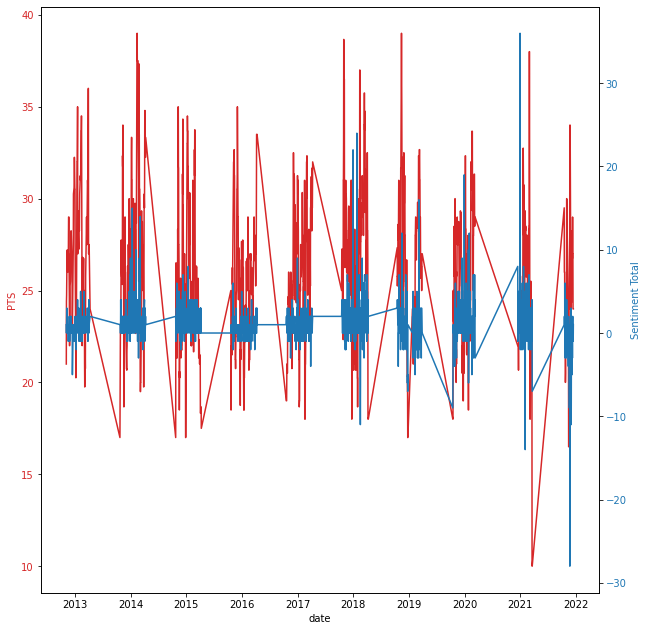

In [19]:
lebron_data = tweets_stats_merged[tweets_stats_merged['player_id'] == 2544]
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('PTS', color=color)
ax1.plot(lebron_data['date'], lebron_data['PTS'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sentiment Total', color=color)  # we already handled the x-label with ax1
ax2.plot(lebron_data['date'], lebron_data['sentiment_value_tot'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_size_inches(10, 10)
plt.show()
